In [1]:
# import python library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer  # Perbaikan penulisan ColumnTransformer

# import joopml library 
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model  # Perbaikan penulisan utils
from jcopml.plot import plot_missing_value 
from jcopml.feature_importance import mean_score_decrease

C:\Minicoda 3\envs\jcopml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read data form csv

df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


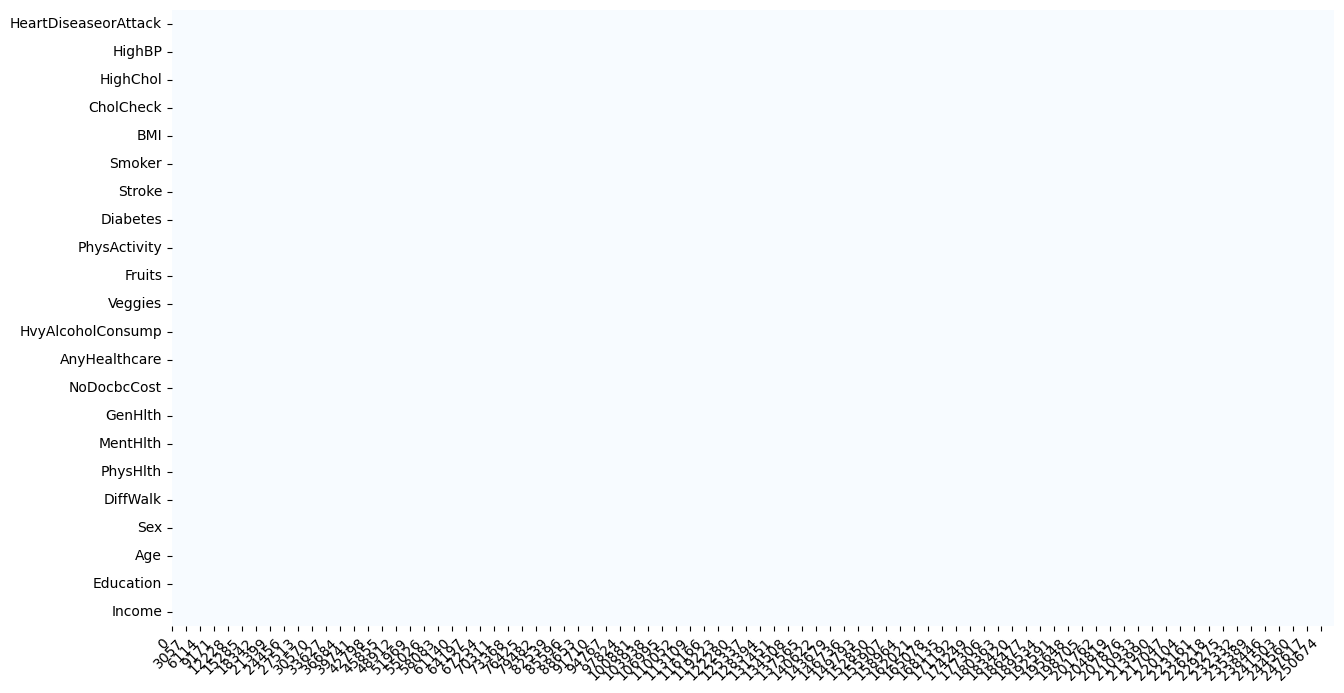

In [3]:
# cek data 
plot_missing_value(df)

In [4]:
df.value_counts(normalize=True)

HeartDiseaseorAttack  HighBP  HighChol  CholCheck  BMI   Smoker  Stroke  Diabetes  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age   Education  Income
0.0                   0.0     0.0       1.0        21.0  0.0     0.0     0.0       1.0           1.0     1.0      0.0                1.0            0.0          1.0      0.0       0.0       0.0       0.0  6.0   6.0        8.0       0.000233
                                                   23.0  0.0     0.0     0.0       1.0           1.0     1.0      0.0                1.0            0.0          1.0      0.0       0.0       0.0       0.0  6.0   6.0        8.0       0.000217
                                                                                                                                                                                                             7.0   6.0        8.0       0.000209
                                                

In [5]:
# Spliting dataset (80% dan 20%)
X = df.drop(columns="HeartDiseaseorAttack")
y = df["HeartDiseaseorAttack"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (202944, 21)
Shape of X_test: (50736, 21)
Shape of y_train: (202944,)
Shape of y_test: (50736,)


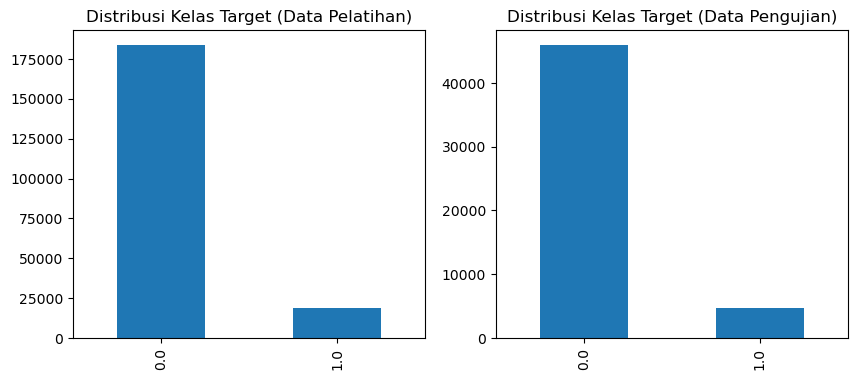

In [6]:
# visualisasi dengan bar 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar')

plt.title('Distribusi Kelas Target (Data Pelatihan)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar')
plt.title('Distribusi Kelas Target (Data Pengujian)')
plt.show()

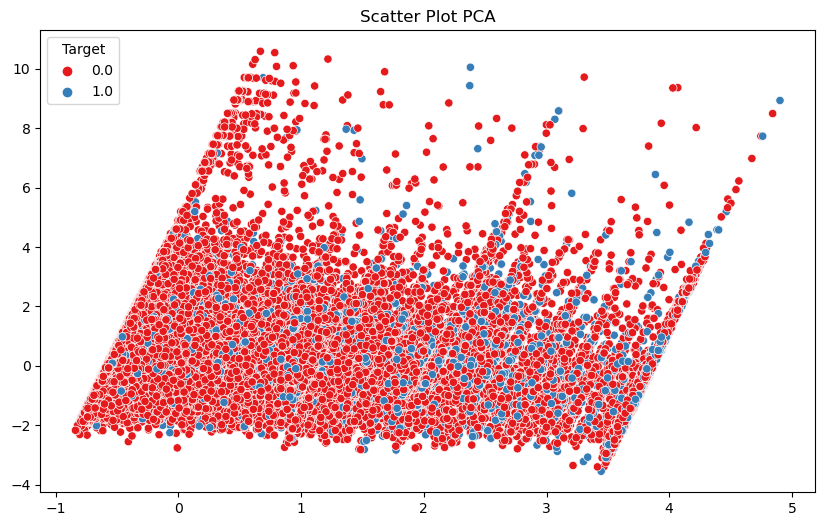

In [7]:
# visualisasi dengan scatterplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 

pca = PCA(n_components=2, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test) 

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="Set1")
plt.title("Scatter Plot PCA")
plt.legend(title="Target")
plt.show()

In [8]:
# tunning
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Real, Integer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
rsp.svm_params

{'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

In [11]:
# Tunning

# Preprocessor untuk data numerik
num_transformer = StandardScaler() 

preprocessor = ColumnTransformer([
    ('numeric', num_transformer, X_train.columns)
])

# Pipeline dengan PCA dan SVC
pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA()),
    ('algo', SVC(max_iter=500))
])

# Parameter untuk RandomizedSearchCV
parameter = {
    'pca__n_components': Integer(1, 22),
    'pca__whiten': [True, False],
    'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
    'algo__C': Real(low=-3, high=3, prior='log-uniform')
}

# Lakukan Randomized Search
model = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=1, verbose=1, random_state=42)
model.fit(X_train, y_train)

# Hasil terbaik
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

{'algo__C': 0.05589524205217925, 'algo__gamma': 4.689400963537697, 'pca__n_components': 10, 'pca__whiten': False}
0.9061071034374014 0.905151174708294 0.9052546515294859


In [10]:
pca = PCA().fit(X_train)

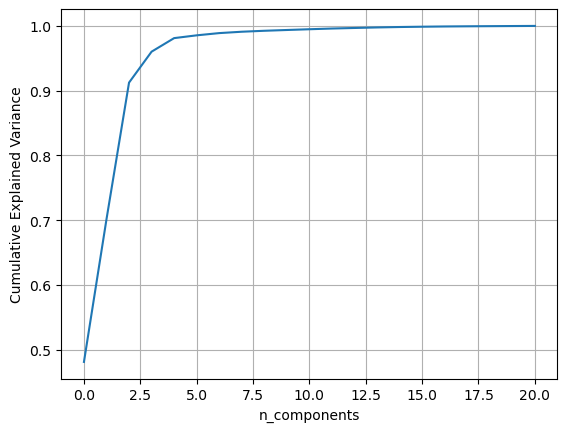

In [11]:
cumulative_explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
plt.plot(cumulative_explained_variance_ratio)
plt.xlabel("n_components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [12]:
# test after reduce pca 

# Preprocessor untuk data numerik
num_transformer = StandardScaler() 

preprocessor = ColumnTransformer([
    ('numeric', num_transformer, X_train.columns)
])

# Pipeline dengan PCA dan SVC
pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(n_components=5, whiten=True)),
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=1, verbose=1, random_state=42)
model.fit(X_train, y_train)

# Hasil terbaik
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Minicoda 3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=

{'algo__C': 0.5450293694558256, 'algo__gamma': 51.41096648805754}
0.9065801403342794 0.9052103043204037 0.9053532008830022


### kesimpulan ###

### pca__n_components': Integer(1, 22) ###
Pada saat melakukan percobaan pertama dengan n_components nya 22 aslinya feature lalu di compres menjadi 1 feature secara random  menggunakan randomsearchCV dan mendapatkankan pca__n_components': 10 yg merupakan feature penting saling berkaitan dengan. akurasi nya sekitar :

{'algo__C': 0.05589524205217925, 'algo__gamma': 4.689400963537697, 'pca__n_components': 10, 'pca__whiten': False}
0.9061071034374014 0.905151174708294 0.9052546515294859

### PCA(n_components=5 ### 
Untuk memastikan bahwa sudah di reduce dengan baik maka kita mencoba untuk PCA(n_components=5) apakah lebih saling ada keterkaitannya juga kita reduce lagi ke-5 dengan tujuan apakah indikasi performance lebih baik atau tidak dan hasilnya : 

{'algo__C': 0.5450293694558256, 'algo__gamma': 51.41096648805754}
0.9065801403342794 0.9052103043204037 0.9053532008830022

ada peningkatan sedikit walau tidak signifikat untuk keterkaitan feature - feature tersebut dengan menggunakan metode unsupervised-learning_PCA 